In [121]:
from prysm import geometry, coordinates, polynomials, detector
from prysm.propagation import Wavefront as WF
from prysm.segmented import _local_window
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from astropy.io import fits
import cv2 as cv


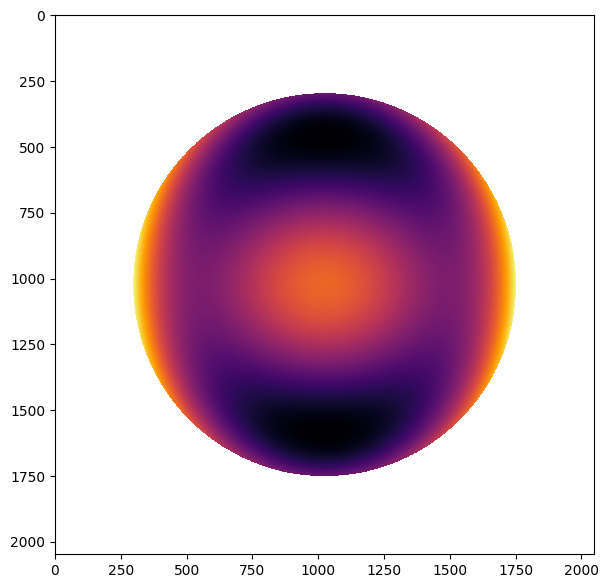

In [122]:
x, y = coordinates.make_xy_grid(2048, diameter=14) #14mm 'diameter', aiming to be imaged by an imx533 11.31mm x 11.31mm square sensor
r, t = coordinates.cart_to_polar(x, y)
dx = x[0,1]-x[0,0]

#optical system paramters, a 5mm wavefront radius at 650nm
rmax = 5
wvl = 0.650

amp = geometry.circle(rmax, r)
phs = polynomials.zernike_nm(4,0, r/rmax, t) # Zernike flavor spherical aberration
phs += (polynomials.zernike_nm(2,2, r/rmax, t)) # Zernike flavor astig




nwaves_aber = 5
phs = phs * (wvl*1e3 * nwaves_aber)

#plot the wavefront phase at points where the aperture hasn't stopped it
phi2 = phs.copy()
phi2[amp!=1]=np.nan
plt.figure(figsize=(7,7))

#plt.colorbar(phi2)
plt.imshow(phi2, cmap='inferno')

plt.show()

wf = WF.from_amp_and_phase(amp, phs, wvl, dx)

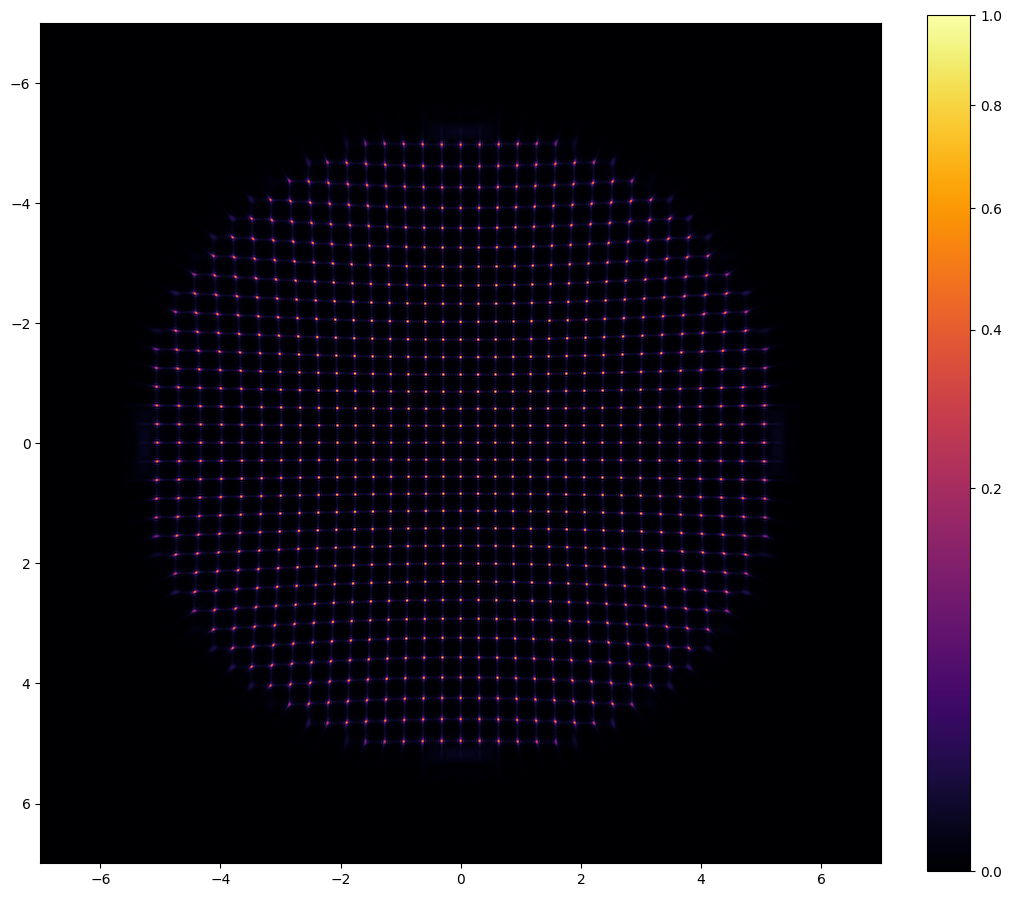

In [123]:
def shack_hartmann_phase_screen(x, y, pitch, n, efl, wavelength, aperture=geometry.rectangle):
    if not hasattr(n, '__iter__'):
        n = (n,n)

    dx = x[0,1] - x[0,0]
    samples_per_lenslet = int(pitch / dx + 1) # ensure safe rounding

    xc, yc = coordinates.make_xy_grid(n, dx=pitch, grid=False)
# if you use prysm's plotting utilities, they shear things a bit to be "FFT aligned"
# and doing this will make the center of the beam not contain a lenslet
# uncomment this if you want symmetric lenslets across the origin, instead
# of having a lenslet at the origin

#     if not is_odd(n[0]):
#         # even number of lenslets, FFT-aligned make_xy_grid needs positive shift
#         xc += (pitch/2)
#     if not is_odd(n[1]):
#         yc += (pitch/2)

    cx = ceil(x.shape[1]/2)
    cy = ceil(y.shape[0]/2)
    lenslet_rsq = (pitch/2)**2
    total_phase = np.zeros_like(x)
    for j, yy in enumerate(yc):
        for i, xx in enumerate(xc):
            iy, ix = _local_window(cy, cx, (xx,yy), dx, samples_per_lenslet, x, y)
            lx = x[iy, ix] - xx
            ly = y[iy, ix] - yy
            rsq = lx * lx + ly * ly
            phase = rsq / (2*efl)
            phase *= aperture(pitch/2, lx, ly)
# swap the aperture here if you fancy
#             phase *= geometry.circle(lenslet_rsq, rsq)
            total_phase[iy, ix] += phase

    prefix = -1j * 2 * np.pi/(wavelength/1e3)
    return np.exp(prefix*total_phase)


# above this is your "library" code

# diameter here is the beam in mm, need to assume some sort of magnification between your telescope
# and the SH-WFS
#
# also, if you fiddle with the SH-WFS lenslet parameters, they are quite sensitive and easy to drive the model
# into an undersampled regime (need more samples)
# or have the lenslet PSFs overlap because the F/# is so big.  Delicate balancing act.



efl = 14.6
mask = shack_hartmann_phase_screen(x, y, pitch=.3, n=33, efl=efl, wavelength=wvl)
wf = wf * mask
wf2 = wf.free_space(dz=efl, Q=1)
i = wf2.intensity
i.data /= i.data.max()

hdu = fits.PrimaryHDU(i.data)
hdu.writeto('prysm_sh_capture.fits', overwrite=True)
fig, ax = plt.subplots(figsize=(12,12))
i.plot2d(power=1/2,  interpolation='lanczos',  fig=fig, ax=ax)
plt.show()

Image min: 791 and max: 934


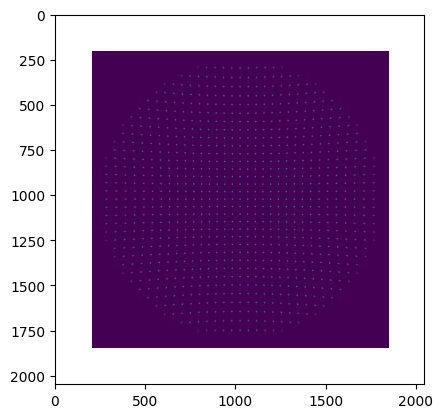

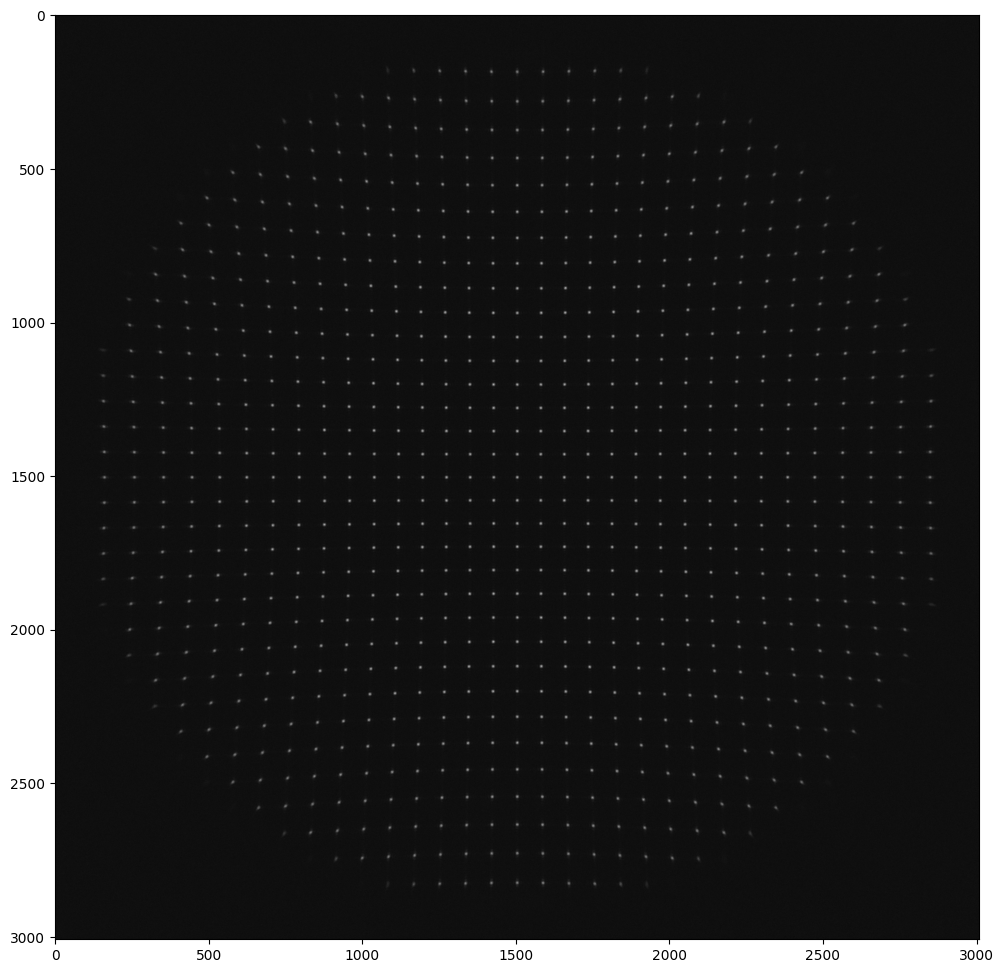

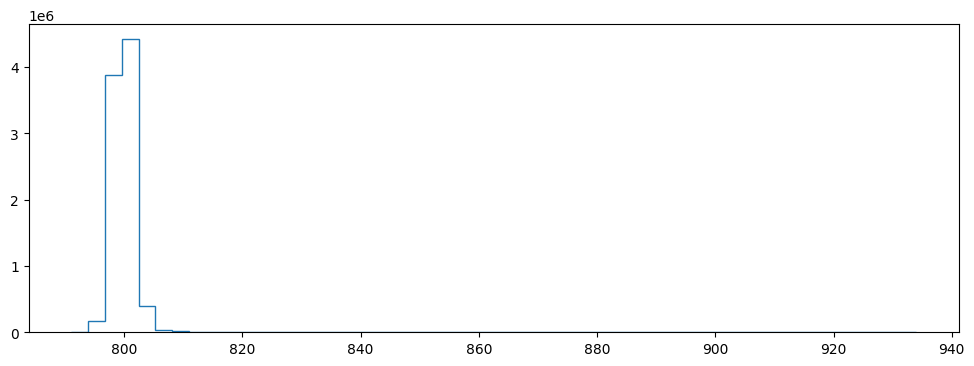

In [131]:
peak_eminus = 100 #intensity of light 

#sensor parameters - notionally an imx533 at 25C
dark_current = 0.06250
fwc = 50_000
rn = 1.5
bias = 800
kgain = 1
bit_depth = 14
texp = 0.25 #1 sec
cam = detector.Detector(dark_current, rn, bias, fwc, kgain, bit_depth, texp)

#now we need to take the area the the sensor will observe out of the simulation coordinate space and convert to pixels
sensor_width = 11.31
sensor_height = sensor_width

sensor_area_x = (sensor_width/2  >= x) & (-1*sensor_width/2  <= x)
sensor_area_y = (sensor_height/2 >= y) & (-1*sensor_height/2  <= y)
sensor_area = sensor_area_x & sensor_area_y
i_sens = i.data.copy()
i_sens[sensor_area!=True]=np.nan 
plt.imshow(i_sens)

#now actually grab the relevant sensor indicies out of the full simulation xy space
sensor_field_indicies = np.where(sensor_area == True)
sensor_field = i.data[sensor_field_indicies[0][0]:sensor_field_indicies[0][-1],sensor_field_indicies[1][0]:sensor_field_indicies[1][-1]]

#resample to the simulation plane to pixels
sensor_width_npx = 3008
sensor_height_npx = sensor_width_npx
img2 = cv.resize(sensor_field, dsize=(sensor_height_npx, sensor_width_npx))

im = cam.expose(img2*peak_eminus)
plt.figure(figsize=(12,12))
plt.imshow(im, cmap='gray')


#some stats from the image to check exposure
print(f"Image min: {np.min(im)} and max: {np.max(im)}")
plt.figure(figsize=(12,4))
counts, bins = np.histogram(im, bins=50)
plt.stairs( counts, bins)